## ***BMI707 - Group project: Predicting Malaria Infection from Red Blood Cell Images using CNN***

## **Loading packages**

In [ ]:
# Basic data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,
                          Dropout, Activation, GlobalAveragePooling2D)
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Image processing libraries
import cv2
import PIL
from PIL import Image
from IPython.display import Image, display

# Utilities for handling files and directories
import os
import shutil

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## **Downloading dataset from kagle**

In [ ]:
# To re-run here, you need your kaggle API key, that you download as a json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anntuk","key":"b5136de1d1d14a64b609eb2e9e8730b1"}'}

In [ ]:
# Install the Kaggle API Python package in quiet mode (suppress unnecessary output)
!pip install -q kaggle

# Create a directory named '.kaggle' in the user's home directory if it doesn't already exist
!mkdir -p ~/.kaggle

# Copy the 'kaggle.json' file (contains the Kaggle API key) to the '.kaggle' directory
!cp kaggle.json ~/.kaggle/

# Set the permissions for the 'kaggle.json' file to protect the API key from unauthorized access
# (owner has read and write permissions; group and others have no permissions)
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset 'cell-images-for-detecting-malaria' by user 'iarunava'
# from Kaggle using the Kaggle API
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:24<00:00, 32.0MB/s]
100% 675M/675M [00:24<00:00, 29.0MB/s]


In [ ]:
# unzip dataset quitely
!unzip -q cell-images-for-detecting-malaria.zip

In [ ]:
# Remove duplicates cell_images folder inside the main cell_images folder
shutil.rmtree("/content/cell_images/cell_images")

## **Loading data set and image processing**

In [ ]:
# Path to main data set directory
data_dir = '/content/cell_images'

# Path to Parasitized and Uninfected directories
para_dir = os.path.join(data_dir, 'Parasitized')
unin_dir = os.path.join(data_dir, 'Uninfected')

# Path to each image within respective directories
para_images = [os.path.join(para_dir, file) for file in os.listdir(para_dir) if file.endswith('.png')]
unin_images = [os.path.join(unin_dir, file) for file in os.listdir(unin_dir) if file.endswith('.png')]

# Combine paths of images from both directories
image_paths = para_images + unin_images

# Creating labels for parasitized images `1` and uninfected images `0`
labels = [1] * len(para_images) + [0] * len(unin_images)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

## ***Baseline Model: Random Forest Classifier***

In [ ]:
# Pre-preprocess Data

# Train
train_arrays = np.empty((len(X_train), 64*64*3), dtype=np.uint8)
for i, image_path in enumerate(X_train):
  image = PIL.Image.open(image_path)
  image = image.resize((64,64))
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  train_arrays[i] = image_array.flatten()

# Test
test_arrays = np.empty((len(X_val), 64*64*3), dtype=np.uint8)
for i, image_path in enumerate(X_val):
  image = PIL.Image.open(image_path)
  image = image.resize((64,64))
  image_sequence = image.getdata()
  image_array = np.array(image_sequence)
  test_arrays[i] = image_array.flatten()

In [ ]:
# Now fit the classifier with the preprocessed data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_arrays, y_train)

# Make predictions on the preprocessed validation data
y_val_probs = rf_classifier.predict_proba(test_arrays)[:, 1]
y_val_pred = rf_classifier.predict(test_arrays)
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
auc_score = auc(fpr, tpr)

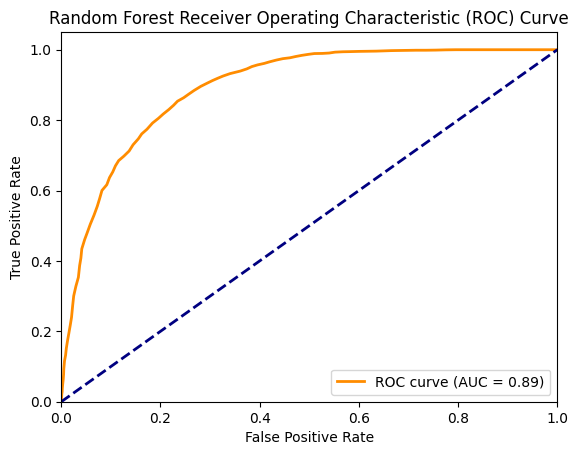

Accuracy : 0.805878084179971
AUC Score: 0.8918072404633458


In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print("Accuracy :",accuracy_score(y_val, y_val_pred))
print("AUC Score:", roc_auc_score(y_val,y_val_probs))



**Infected images**

In [ ]:
from PIL import Image

In [ ]:
DATA_DIR = '/content/cell_images/'
SIZE = 64

x = []
y = []

# set label as 1

parasitized_images = os.listdir(DATA_DIR + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Parasitized/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            #normalizing images
            x.append(np.array(image)/255)
            y.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

**Uninfected images**

In [ ]:
# set label as 0

uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            #normalizing images
            x.append(np.array(image)/255)
            y.append(0)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

**Displaying parasitized and uninfected cells pre-processing**

<ipython-input-14-94e90d6b7855>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, ind+1)


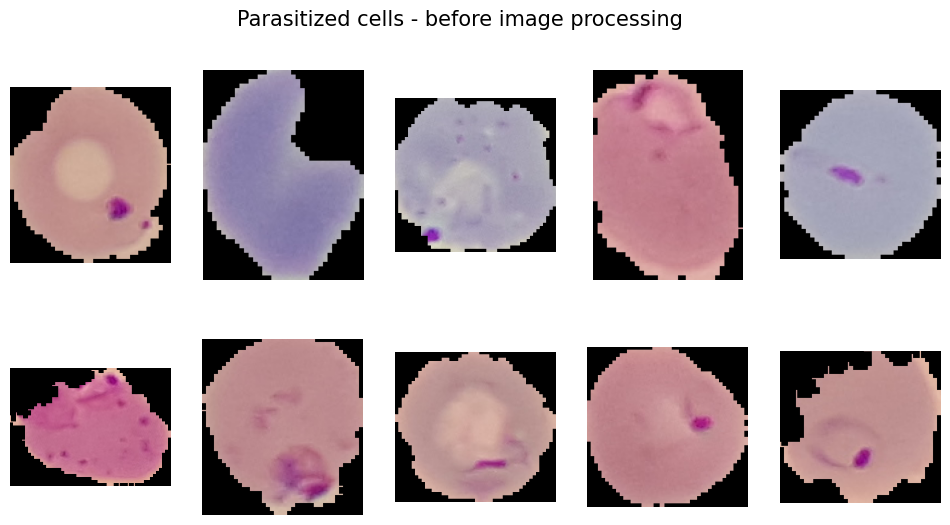

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Parasitized cells - before image processing', fontsize=15)

for ind, img_src in enumerate(parasitized_images[:10]):
    plt.subplot(2, 5, ind+1)
    img = plt.imread(DATA_DIR + 'Parasitized/' +img_src)
    plt.axis('off')
    plt.imshow(img)

<ipython-input-15-568973c08ec5>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, ind+1)


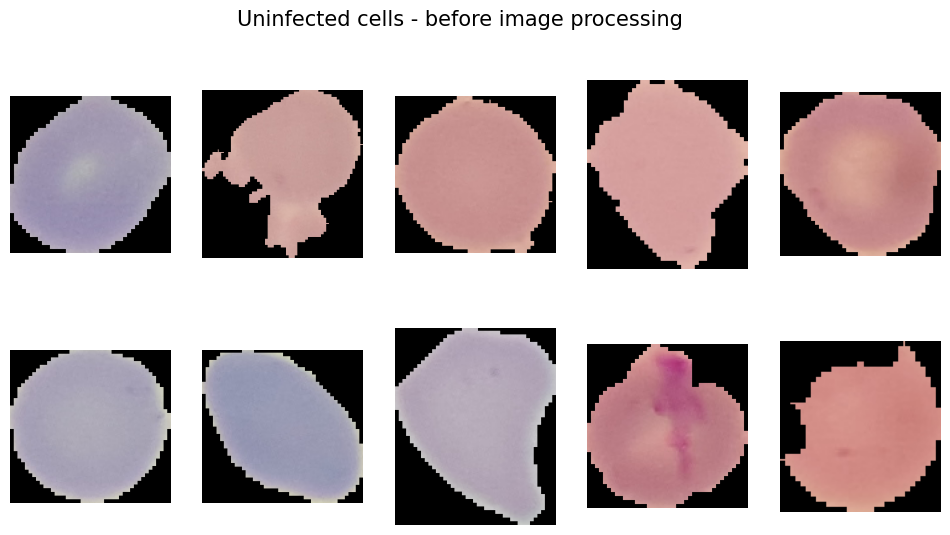

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Uninfected cells - before image processing', fontsize=15)

for ind, img_src in enumerate(uninfected_images[:10]):
    plt.subplot(2, 5, ind+1)
    img = plt.imread(DATA_DIR + 'Uninfected/' +img_src)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
x.shape

(27558, 64, 64, 3)

In [ ]:
y.shape

(27558,)

Displaying processed images

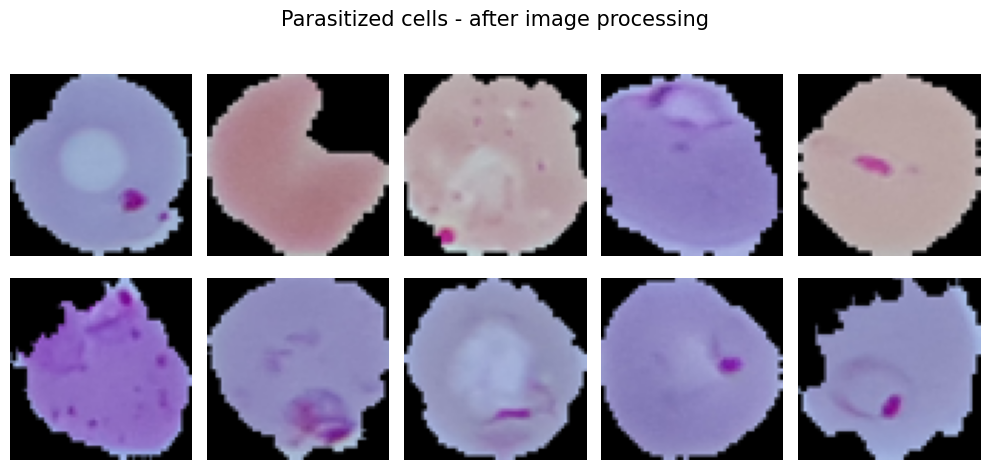

In [ ]:
#processed images - parasitized
count = -1
fig, axs = plt.subplots(2,5, figsize=(10,5))
for i, img in enumerate(x):
    if y[i] == 1:
        count += 1
        if count >= 10: break
        axs.ravel()[count].imshow(img)
        axs.ravel()[count].axis('off')
plt.suptitle('Parasitized cells - after image processing', fontsize=15)
plt.tight_layout();

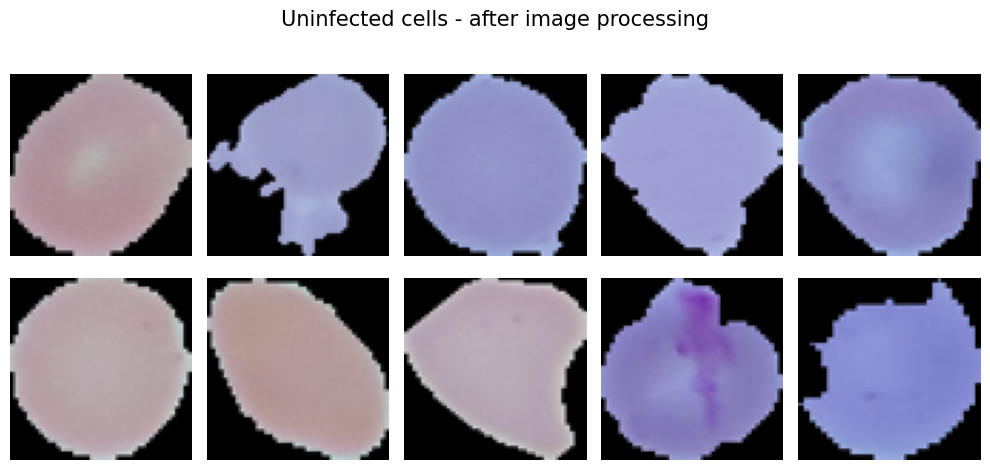

In [ ]:
#processed images - uninfected
count = -1
fig, axs = plt.subplots(2,5, figsize=(10,5))
for i, img in enumerate(x):
    if y[i] == 0:
        count += 1
        if count >= 10: break
        axs.ravel()[count].imshow(img)
        axs.ravel()[count].axis('off')
plt.suptitle('Uninfected cells - after image processing', fontsize=15)
plt.tight_layout();

Dividing data into train and test sets

In [ ]:
#datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
#trainDatagen = datagen.flow(x_train, y_train, subset='training', batch_size=16, shuffle=True, seed=42)
#valDatagen = datagen.flow(x_val, y_val, subset='validation', batch_size=16, shuffle=True, seed = 42)

In [ ]:
#trainDatagen = datagen.flow_from_directory(directory='/content/cell_images',
                                           #target_size=(64,64),
                                           #class_mode = 'binary',
                                           #batch_size = 16,
                                           #subset='training')

In [ ]:
#valDatagen = datagen.flow_from_directory(directory='/content/cell_images',
                                          # target_size=(64,64),
                                          # class_mode = 'binary',
                                          # batch_size = 16,
                                          # subset='validation')

Image Augmentation

VGG

In [ ]:
from tensorflow.python.ops.math_ops import Max
from keras.applications import VGG19
from keras.optimizers import Adam
from tensorflow.keras.models import Model

vggmod = VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))

for layer in vggmod.layers:
    layer.trainable = False

x = vggmod.output
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vggmod.input, outputs=x)

# Compile the model
optimizer= Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

batch_size = 10

mod = model.fit(
        x= x_train,
        y = y_train,
        #steps_per_epoch = len(x_train) // batch_size ,
        epochs=5,
        validation_data=(x_val, y_val))
        #validation_steps = len(x_val)//batch_size)


80134624/80134624 [==============================] - 3s 0us/step
Epoch 1/5
689/689 [==============================] - 34s 33ms/step - loss: 0.3182 - accuracy: 0.8633 - auc: 0.9388 - val_loss: 0.2537 - val_accuracy: 0.8991 - val_auc: 0.9610
Epoch 2/5
689/689 [==============================] - 20s 30ms/step - loss: 0.2409 - accuracy: 0.9071 - auc: 0.9644 - val_loss: 0.2240 - val_accuracy: 0.9118 - val_auc: 0.9693
Epoch 3/5
689/689 [==============================] - 19s 27ms/step - loss: 0.2246 - accuracy: 0.9132 - auc: 0.9689 - val_loss: 0.2125 - val_accuracy: 0.9175 - val_auc: 0.9725
Epoch 4/5
689/689 [==============================] - 21s 30ms/step - loss: 0.2109 - accuracy: 0.9208 - auc: 0.9723 - val_loss: 0.2062 - val_accuracy: 0.9233 - val_auc: 0.9744
Epoch 5/5
689/689 [==============================] - 21s 31ms/step - loss: 0.2038 - accuracy: 0.9217 - auc: 0.9741 - val_loss: 0.2062 - val_accuracy: 0.9224 - val_auc: 0.9749


In [ ]:
from tensorflow.python.ops.math_ops import Max
from keras.applications import VGG19
from keras.optimizers import Adam
from tensorflow.keras.models import Model

vggmod_u = VGG19(include_top=False, weights=None, input_shape=(64,64,3))

for layer in vggmod_u.layers:
    layer.trainable = True

x = vggmod_u.output
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=vggmod_u.input, outputs=x)

# Compile the model
optimizer= Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

mod_u = model2.fit(
        x = x_train, y = y_train,
        epochs=5,
        validation_data=(x_val, y_val))

Evaluate
AUC & accuracy

In [ ]:
plt.plot(range(1, 6), mod.history['accuracy'])
plt.plot(range(1,6), mod.history['val_accuracy'])

In [ ]:
plt.plot(range(1, 6), mod_u.history['accuracy'])
plt.plot(range(1,6), mod_u.history['val_accuracy'])

## ***Model Interpretability: GRAD-CAM***

In [ ]:
# Grad-CAM for model interpretability
# https://keras.io/examples/vision/grad_cam/

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 256x256
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256, 256, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
 # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, figsize=(10, 10)):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    #jet = plt.colormaps.get_cmap("jet")
    #jet = plt.cm.get_cmap("Reds")
    # Create a custom intense dark colormap
    colors = ["black", "darkred", "darkblue", "darkgreen"]
    jet = LinearSegmentedColormap.from_list("intense_dark", colors)

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

    fig = plt.figure(figsize=figsize)
    plt.imshow(superimposed_img)
    plt.show()

## ***Using Imagenet Weights***

In [ ]:
from PIL import Image

In [ ]:
# # Parasitized Image
# img_path = '/content/cell_images/Parasitized/C101P62ThinF_IMG_20150918_151006_cell_69.png'

# #Unparasitized Image
# #img_path = '/content/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_40.png'

# model_builder = keras.applications.VGG19
# img_size = (64,64)
# preprocess_input = keras.applications.vgg19.preprocess_input
# decode_predictions = keras.applications.vgg19.decode_predictions

# last_conv_layer_name = 'block5_pool'

# display(Image(img_path))

from IPython.display import Image as IPImage

# Parasitized Image
img_path = '/content/cell_images/Parasitized/C101P62ThinF_IMG_20150918_151006_cell_69.png'

# Unparasitized Image
# img_path = '/content/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_40.png'

model_builder = keras.applications.VGG19
img_size = (64,64)
preprocess_input = keras.applications.vgg19.preprocess_input
decode_predictions = keras.applications.vgg19.decode_predictions

last_conv_layer_name = 'block5_pool'

display(IPImage(img_path))

In [ ]:
#model.layers[-1].activation = None

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

preds = model.predict(img_array)

#Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap, figsize=(5, 5))

In [ ]:
preds

## ***Using dataset training weights***

In [ ]:
# # Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# # Display heatmap
# plt.matshow(heatmap)
# plt.show()

# save_and_display_gradcam(img_path, heatmap)

In [ ]:
!pip install pillow